# COMP4434 Big Data Analytics - Individual Project

#20037676D Leung Chun Kit

#Introduction
AlphaMoney is a platform for issuing loans. For people who want to borrow money from the AlphaMoney platform, the platform requires them to provide relevant personal information to decide the Loan Amount. The platform has collected personal information from users, including Gender, Age, Credit Score, Property Age, Profession, Loan Amount Request, Property Price and Income Stability, etc., and determined the Loan Amount based on them.


In this project, I will use two model (Linear Regression and DNN) to predict the Loan amount of the providing dataset.


# Data preprocessing/analytics

##Reading Data set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

Drop the rows with 4 or more mssing values

In [3]:
train_df.dropna(subset=['Loan Amount'], inplace=True)
train_df.dropna(thresh=len(train_df.columns)-4, inplace=True)
train_df['Customer ID'].drop_duplicates(inplace=True)

Merge the traning and testing data set

In [4]:
df = pd.concat([train_df, test_df])

Drop the row with duplicate Customer ID

In [5]:
df['Customer ID'].drop_duplicates(inplace=True)

##Function of creating dummy variable

In [6]:
def creat_dummies(df, column_name):
  # get the dummies and store it in a variable
  dummies = pd.get_dummies(df[column_name])
  # Concatenate the dummies to original dataframe
  merged = pd.concat([df, dummies], axis=1)
  # drop the values
  merged.drop([column_name], axis=1, inplace=True)
  return merged

##Column - Name
Customer name is clearly not related to the loan amount, so drop this column

In [7]:
df.drop("Name", axis=1, inplace=True)

##Column - Gender
There are 51 missing values

In [8]:
df['Gender'].value_counts(dropna=False)

M      14881
F      14704
NaN       51
Name: Gender, dtype: int64

The gender distribution is nearly evenly distributed, so fill the missing value from randomly choose from other values.


First create a funtion of filling missing data by random choosing from non missing values in column.

In [9]:
def randomiseMissingData(df2, column_name):
    "randomise missing data for DataFrame (within a column)"
    df = df2.copy()
    data = df[column_name]
    mask = data.isnull()
    samples = random.choices( data[~mask].values , k = mask.sum() )
    data[mask] = samples
    return df

Filling missing data by random choosing from non missing values

In [10]:
df = randomiseMissingData(df, 'Gender')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [11]:
df['Gender'].value_counts(dropna=False)

M    14910
F    14726
Name: Gender, dtype: int64

Replace with dummy variable columns

In [12]:
df = creat_dummies(df,'Gender')

##Column - Age
No missing value in "Age", also no extreme value (too young or too old) in both data set.

In [13]:
df['Age'].value_counts(dropna=False)

18    4326
65    1335
64     806
61     779
62     768
60     761
63     703
47     534
57     532
23     516
44     516
45     514
58     511
28     511
50     510
26     510
34     508
41     507
27     506
42     504
21     504
38     500
53     500
24     499
39     497
56     497
30     497
20     495
43     489
33     487
32     487
36     487
29     487
59     485
55     484
48     480
19     480
52     478
51     478
46     477
31     475
37     472
35     468
25     464
22     462
49     451
40     451
54     448
Name: Age, dtype: int64

##Column - Income (USD)
Rename this column with "Income"

There are no negative value in this column

In [14]:
df.rename(columns={'Income (USD)':'Income'}, inplace=True)

df.Income.isna().sum(), df['Income'][df['Income']<0]

(4431, Series([], Name: Income, dtype: float64))

Graph of Income againist Loan Amount

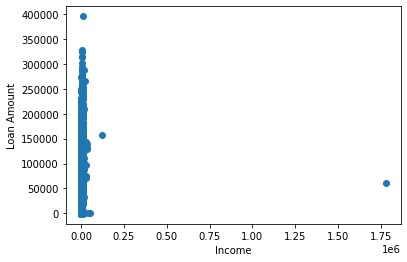

In [15]:
plt.scatter(df['Income'], df['Loan Amount'])
plt.xlabel('Income')
plt.ylabel('Loan Amount')
plt.show()

From the graph, There is a value with extremely high value.

This row the in training dataset, so frop this row

In [16]:
print(df.loc[df['Income']==df['Income'].max(), ['Income', 'Loan Amount']])
df.drop(df['Income'].idxmax(), inplace=True)

          Income  Loan Amount
5822  1777460.21      61415.1


Graph of Income againist Loan Amount again

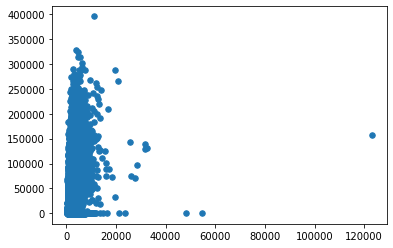

In [17]:
plt.scatter(df['Income'], df['Loan Amount'],s=30)
plt.show()

Fill the missing value with the median of the two dataset

In [18]:
df.Income.fillna(df.Income.median(), inplace=True)

##Column - Income Stability
There are 2 type of value except "nan" 
Most of them is "Low"

Low     25475
High     2540
NaN      1620
Name: Income Stability, dtype: int64


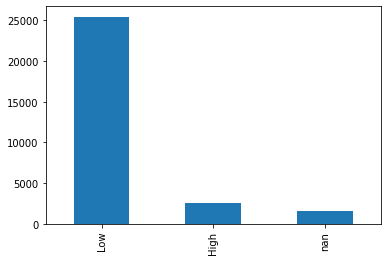

In [19]:
print(df["Income Stability"].value_counts(dropna=False))
df["Income Stability"].value_counts(dropna=False).plot(kind='bar')

Fill the missing value with the mode of the two dataset

In [20]:
df["Income Stability"].fillna(df["Income Stability"].mode()[0], inplace=True)

Turn the values to numeric by replacing 'Low' with 0 and 'High' with 1

In [21]:
df["Income Stability"].replace(['Low', 'High'], [0,1], inplace=True)

##Column - Profession
There are 8 types of categorical values and no missing value

Working                 16736
Commercial associate     7860
Pensioner                2700
State servant            2333
Businessman                 2
Unemployed                  2
Maternity leave             1
Student                     1
Name: Profession, dtype: int64


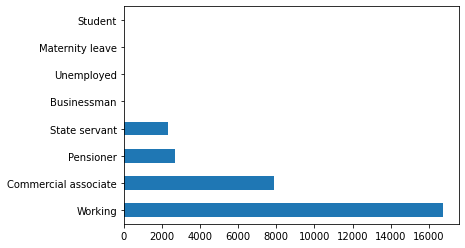

In [22]:
print(df["Profession"].value_counts(dropna=False))
df["Profession"].value_counts(dropna=False).plot(kind='barh')

Replace with dummy variable columns



In [23]:
df = creat_dummies(df, "Profession")

##Column - Type of Employment
There are 18 types of of Employment

There are 1/4 of rows are missing value


NaN                      7146
Laborers                 5525
Sales staff              3698
Core staff               3190
Managers                 2467
Drivers                  1587
Accountants              1367
High skill tech staff    1297
Medicine staff            853
Security staff            575
Cooking staff             561
Cleaning staff            338
Private service staff     338
Secretaries               158
Low-skill Laborers        154
Waiters/barmen staff      148
Realty agents              85
IT staff                   77
HR staff                   71
Name: Type of Employment, dtype: int64


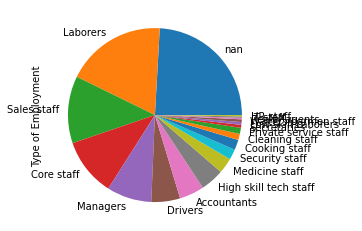

In [24]:
print(df["Type of Employment"].value_counts(dropna=False))
df["Type of Employment"].value_counts(dropna=False).plot(kind='pie')

Filling missing data by random choosing from non missing values


In [25]:
df = randomiseMissingData(df, 'Type of Employment')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Replace with dummy variable columns

In [26]:
df = creat_dummies(df,'Type of Employment')

##Column - Location
There are 3 types of "Location", no missing value


Semi-Urban    21309
Rural          5273
Urban          3053
Name: Location, dtype: int64


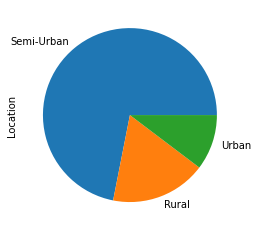

In [27]:
print(df["Location"].value_counts(dropna=False))
df["Location"].value_counts(dropna=False).plot(kind='pie')

Replace with dummy variable columns

In [28]:
df = creat_dummies(df, "Location")

##Column - Loan Amount Request (USD)
Rename this column with "Loan Amount Request"

There are no missing value


0


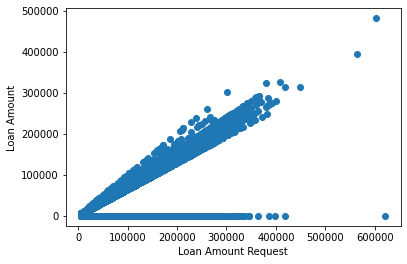

In [29]:
df.rename(columns={'Loan Amount Request (USD)':'Loan Amount Request'}, inplace=True)

print(df['Loan Amount Request'].isna().sum())

plt.scatter(df['Loan Amount Request'], df['Loan Amount'])
plt.xlabel('Loan Amount Request')
plt.ylabel('Loan Amount')
plt.show()

##Column - Current Loan Expenses (USD)
Rename this column with "Current Loan Expenses"

There are missing values

In [30]:
df.rename(columns={'Current Loan Expenses (USD)':'Current Loan Expenses'}, inplace=True)

print(df['Current Loan Expenses'].isna().sum())

df['Current Loan Expenses'][df['Current Loan Expenses']<0]

160


129    -999.0
219    -999.0
424    -999.0
456    -999.0
578    -999.0
        ...  
2021   -999.0
2441   -999.0
2660   -999.0
2854   -999.0
2868   -999.0
Name: Current Loan Expenses, Length: 174, dtype: float64

There are many '-999', replace them with median of othe positive values

Also replace the missing value with the 0

In [31]:
df['Current Loan Expenses'].replace({-999, df[df['Current Loan Expenses']>0]['Current Loan Expenses'].median()}, inplace=True)

df['Current Loan Expenses'].fillna(0, inplace=True)

##Column - Expense Type 1
There are 2 types of value, no missing value

N    18975
Y    10660
Name: Expense Type 1, dtype: int64


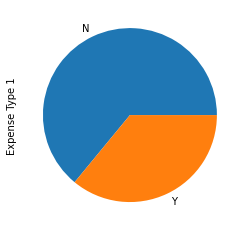

In [32]:
print(df["Expense Type 1"].value_counts(dropna=False))
df["Expense Type 1"].value_counts(dropna=False).plot(kind='pie')

Turn the values to numeric by replacing 'N' with 0 , 'Y' with 1

In [33]:
df["Expense Type 1"].replace(['N', 'Y'], [0,1], inplace=True)

##Column - Expense Type 2
There are 2 types of value, no missing value

Y    19933
N     9702
Name: Expense Type 2, dtype: int64


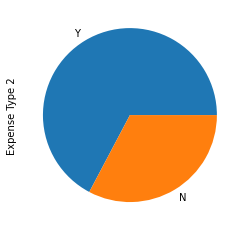

In [34]:
print(df["Expense Type 2"].value_counts(dropna=False))
df["Expense Type 2"].value_counts(dropna=False).plot(kind='pie')

Turn the values to numeric by replacing 'N' with 0 , 'Y' with 1

In [35]:
df["Expense Type 2"].replace(['N', 'Y'], [0,1], inplace=True)

##Column - Dependents


There are missing values

2.0     12970
3.0      5654
1.0      5491
4.0      2682
NaN      2408
5.0       370
6.0        50
7.0         7
14.0        1
10.0        1
8.0         1
Name: Dependents, dtype: int64


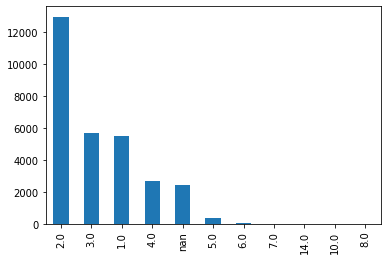

In [36]:
print(df["Dependents"].value_counts(dropna=False))
df["Dependents"].value_counts(dropna=False).plot(kind='bar')

Replace the missing value with 0

In [37]:
df['Dependents'].fillna(0, inplace=True)

##Column - Credit Score
There are no nagetive value

There are missing values

In [38]:
print('range:', df['Credit Score'].min(), df['Credit Score'].max())
print(df['Credit Score'].isna().sum())

range: 580.0 896.26
1637


Replace missing values with median

In [39]:
df['Credit Score'].fillna(df['Credit Score'].median(), inplace=True)

##Column - No. of Defaults
There are only 2 type of value [0, 1], no missing value

0    23884
1     5751
Name: No. of Defaults, dtype: int64


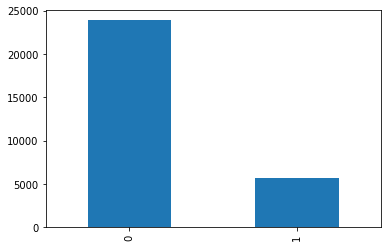

In [40]:
print(df["No. of Defaults"].value_counts(dropna=False))
df["No. of Defaults"].value_counts(dropna=False).plot(kind='bar')

##Column - Has Active Credit Card
There are 3 types of value excluding the missing values

Active         9663
Inactive       9362
Unpossessed    9080
NaN            1530
Name: Has Active Credit Card, dtype: int64


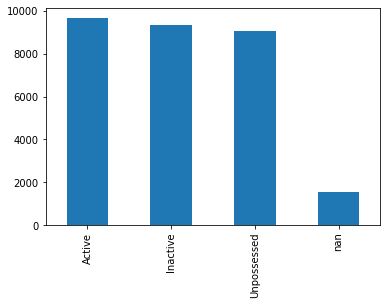

In [41]:
print(df["Has Active Credit Card"].value_counts(dropna=False))
df["Has Active Credit Card"].value_counts(dropna=False).plot(kind='bar')

Filling missing data by random choosing from non missing values

In [42]:
df = randomiseMissingData(df, 'Has Active Credit Card')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Replace by dummy variables

In [43]:
df = creat_dummies(df, "Has Active Credit Card")

##Column - Property ID
Obviously, Property ID will not affect the loan amount

So remove this column

In [44]:
df.drop(['Property ID'], axis=1, inplace=True)

##Column - Property Age
There are no nagative value and 4850 missing values


Plot the graph of Property Age against Loan Amount


range: 377.7 122966.28
4698


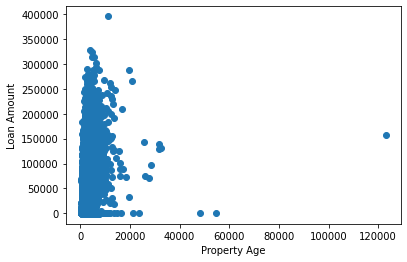

In [45]:
print('range:', df['Property Age'].min(), df['Property Age'].max())
print(df['Property Age'].isna().sum())

plt.scatter(df['Property Age'], df['Loan Amount'])
plt.xlabel('Property Age')
plt.ylabel('Loan Amount')
plt.show()

We can see there is a row with Property Age over 120000, it's twice of the second highest value


This row is in training dataset, so drop this row

In [46]:
print(df.loc[df['Property Age']==df['Property Age'].max(), ['Property Age', 'Loan Amount']])
df.drop(df['Property Age'].idxmax(), inplace=True)

       Property Age  Loan Amount
17305     122966.28    156971.31


Replace missing value with median

In [47]:
df['Property Age'].fillna(df['Property Age'].median(), inplace=True)

##Column - Property Type
There are 4 types of value, no missing value

1    7768
2    7559
3    7218
4    7089
Name: Property Type, dtype: int64


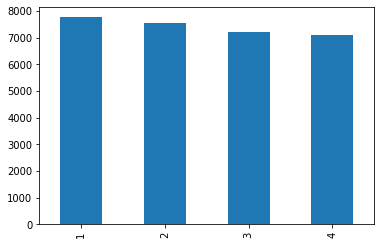

In [48]:
print(df["Property Type"].value_counts(dropna=False))
df["Property Type"].value_counts(dropna=False).plot(kind='bar')

To turn to numerical data, replace with 4 dummy variable columns ( 'Property Type 1', 'Property Type 2', 'Property Type 3', 'Property Type 4' )

In [49]:
def creat_dummies_Property_Type(df, column_name):
  # get the dummies and store it in a variable
  dummies = pd.get_dummies(df[column_name])
  # rename the dummies columns
  dummies.rename(columns={1:'Property Type 1', 2:'Property Type 2', 3:'Property Type 3', 4:'Property Type 4'}, inplace=True)
  # Concatenate the dummies to original dataframe
  merged = pd.concat([df, dummies], axis=1)
  # drop the values
  merged.drop([column_name], axis=1, inplace=True)
  return merged

df = creat_dummies_Property_Type(df, "Property Type")

##Column - Property Location
There are 3 types of value

There are 345 missing values

Semi-Urban    10249
Rural          9920
Urban          9120
NaN             345
Name: Property Location, dtype: int64


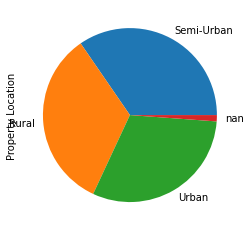

In [50]:
print(df["Property Location"].value_counts(dropna=False))
df["Property Location"].value_counts(dropna=False).plot(kind='pie')

Replace the missing value with mode

In [51]:
df['Property Location'].fillna(df['Property Location'].mode(), inplace=True)

To turn to numerical data, replace with dummy variable columns

In [52]:
def creat_dummies_Property_Location(df, column_name):
  # get the dummies and store it in a variable
  dummies = pd.get_dummies(df[column_name])
  # rename the dummies columns
  dummies.rename(columns={'Semi-Urban':'Semi-Urban Property', 'Rural':'Rural Property', 'Urban':'Urban Property'}, inplace=True)
  # Concatenate the dummies to original dataframe
  merged = pd.concat([df, dummies], axis=1)
  # drop the values
  merged.drop([column_name], axis=1, inplace=True)
  return merged

df = creat_dummies_Property_Location(df, "Property Location")

##Column - Co-Applicant
There are 3 type of values [1, 0, -999], no missing values

 1      25180
 0       4288
-999      166
Name: Co-Applicant, dtype: int64


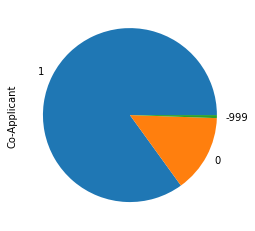

In [53]:
print(df['Co-Applicant'].value_counts(dropna=False))
df['Co-Applicant'].value_counts(dropna=False).plot(kind='pie')

Replace the nagative value (-999) with 0

In [54]:
df['Co-Applicant'].clip(lower=0, inplace=True)

##Column - Property Price
There are some negative values, no missing values

In [55]:
print('range:', df['Property Price'].min(), df['Property Price'].max())
print(df['Property Price'].isna().sum())

range: -999.0 1077966.73
0


Plot the graph of Property Price against Loan Amount

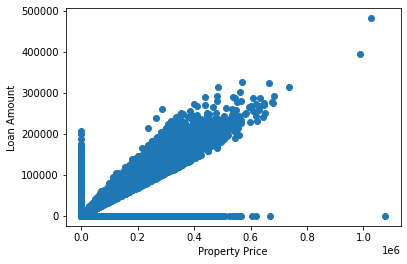

In [56]:
plt.scatter(df['Property Price'], df['Loan Amount'])
plt.xlabel('Property Price')
plt.ylabel('Loan Amount')
plt.show()

Replace the -999 with median of other positive values

In [57]:
df['Property Price'].replace({-999, df[df['Property Price']>0]['Property Price'].median()}, inplace=True)

Split the data back to training data and testing data

In [58]:
test_df = df[df['Loan Amount'].isna()]
test_df.drop('Loan Amount', axis=1, inplace=True)
train_df = df.dropna(subset=['Loan Amount'])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


##Column - Loan Amount

There are some -999 in this column

In [59]:
train_df['Loan Amount'][train_df['Loan Amount']<0]

59      -999.0
320     -999.0
349     -999.0
505     -999.0
620     -999.0
         ...  
26468   -999.0
26728   -999.0
26868   -999.0
26911   -999.0
26985   -999.0
Name: Loan Amount, Length: 300, dtype: float64

Loan Amount is the value that we want to predict, it's so important, can't be easily replaced by mean or median

So just remove the rows with  value "-999" in training dataset


In [60]:
train_df = train_df[train_df['Loan Amount']>=0]

##Column - Customer ID
This row is clearly not related to the Loan Amount, but for testing data, it use to identify each row, so remove this column from training data, pop out from testing data

In [61]:
train_df.drop("Customer ID", axis=1, inplace=True)
test_ID = test_df.pop('Customer ID')

#Model design and implementation

Get the column - 'Loan Amount' from training dataset and let it be y

Also reshape it to (len(y),1)

In [62]:
y = train_df['Loan Amount']
y = y.values.reshape(len(y),1)

Get the other columns from training dataset and let it be x

In [63]:
x = train_df.drop(['Loan Amount'], axis=1)

##Linear Regression Model
The Linear Regression Model is implemented using Gradient Descent Algorithm:

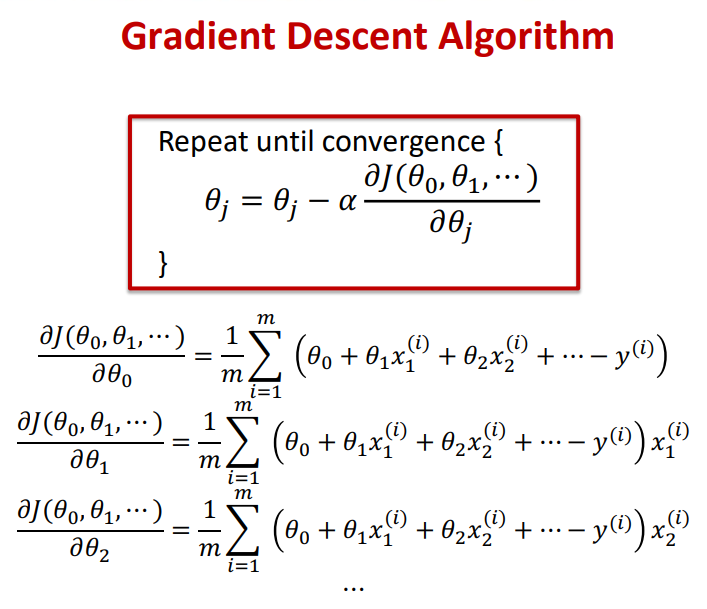



The Linear Regression Model is implemented using Gradient Descent Algorithm


Cost function:
$$J(\theta_0,\theta_1,...)=\frac{1}{2m}\sum_{i=1}^{m}(h_\theta (x^{(i)})-y^{(i)})^2$$

Gradient Descent Algorithm:
$$n=0, \theta[n]=0, x^{(0)}=0$$
REPEAT {
  $$\theta[n+1] = \theta[n]-\frac{\alpha}{m}\sum_{i=1}^{m}(h_\theta (x^{(i)})-y^{(i)})x^{(i)}$$
} UNTIL $$J($$



In [64]:
class LinearRegression:
    """
    Parameters
    ----------
    eta : float
        Learning rate
    eps : float
        Convergence criteria
    n_iterations : int
        No of passes over the training set
   
    Attributes
    ----------
    theta : theta/ after fitting the model
    bias : bias / after fitting the model
    cost : total error of the model after each iteration
    """

    def __init__(self, eta, eps,  n_iterations):
        self.eta = eta
        self.eps = eps
        self.n_iterations = n_iterations

    def fit(self, x, y):
        """Fit the training data

        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Training samples
        y : array-like, shape = [n_samples, n_target_values]
            Target values

        Returns
        -------
        self : object
        """
          
        self.theta = np.zeros((x.shape[1], 1))
        self.bias = 0
        m = x.shape[0]
        self.cost = []
        self.cost.append(self.costfuntion(x,y))
        print('initial cost: ',self.cost)
    
        for i in range(self.n_iterations):
            y_pred = np.dot(x, self.theta)+self.bias
            residuals = y_pred - y
            gradient_vector = np.dot(x.T, residuals)
            self.bias -= (self.eta / m) * np.sum(residuals)
            self.theta -= (self.eta / m) * gradient_vector
            new_cost = self.costfuntion(x,y)
            cost_diff = self.cost[-1]-new_cost
            self.cost.append(new_cost)
            if (i%100 == 0):
              print('itr:',i)
              print('cost:', new_cost)
              print('cost_diff',cost_diff)
            if (cost_diff < self.eps):
              print('itr:',i)
              print('cost:', new_cost)
              print('cost_diff',cost_diff)
              break
        return self

    def costfuntion(self, x, y):
      m = x.shape[0]
      y_pred = np.dot(x, self.theta)+self.bias
      residuals = y_pred - y
      cost = np.sum((residuals ** 2)) / (2 * m)
      return cost


    def predict(self, x):
        """ Predicts the value after the model has been trained.
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Test samples
        Returns
        -------
        Predicted value
        """
        return np.dot(x, self.theta)+self.bias

First lets try traning the model with a low learning rate 0.000005, Convergence criteria 100 and  number of iterations 1000


In [65]:
LR = LinearRegression(0.000005, 1000, 1000)
LR.fit(x, y)

initial cost:  [2322818366.303193]
itr: 0
cost: 6.0738082505837625e+19
cost_diff -6.073808250351481e+19
itr: 0
cost: 6.0738082505837625e+19
cost_diff -6.073808250351481e+19


The cost increase after the first iteration, the learning rate is too high.

Now try with learning rate 0.00000005

In [66]:
LR = LinearRegression(0.00000005, 1000, 1000)
LR.fit(x, y)

initial cost:  [2322818366.303193]
itr: 0
cost: 6067349026490269.0
cost_diff -6067346703671903.0
itr: 0
cost: 6067349026490269.0
cost_diff -6067346703671903.0


The cost increase after the first iteration, the learning rate is still too high.

Now try with learning rate 0.000000000005

In [67]:
LR = LinearRegression(0.000000000005, 1000, 3000)
LR.fit(x, y)

initial cost:  [2322818366.303193]
itr: 0
cost: 1730875618.7026997
cost_diff 591942747.6004934
itr: 100
cost: 562718274.2777449
cost_diff 61750.265167593956
itr: 200
cost: 557305718.6319326
cost_diff 47288.985241532326
itr: 300
cost: 553160423.5102154
cost_diff 36220.160187006
itr: 400
cost: 549985105.4680915
cost_diff 27747.925159573555
itr: 500
cost: 547552223.3031313
cost_diff 21263.124204993248
itr: 600
cost: 545687616.6128525
cost_diff 16299.508588433266
itr: 700
cost: 544257982.7264125
cost_diff 12500.210938572884
itr: 800
cost: 543161291.5324272
cost_diff 9592.08451795578
itr: 900
cost: 542319448.9761701
cost_diff 7366.062466979027
itr: 1000
cost: 541672681.6911314
cost_diff 5662.124744653702
itr: 1100
cost: 541175238.9889727
cost_diff 4357.791806340218
itr: 1200
cost: 540792103.1572505
cost_diff 3359.317651152611
itr: 1300
cost: 540496471.5171684
cost_diff 2594.9489674568176
itr: 1400
cost: 540267829.1874216
cost_diff 2009.765676856041
itr: 1500
cost: 540090473.9752268
cost_dif

Plot the graph of cost over iteration

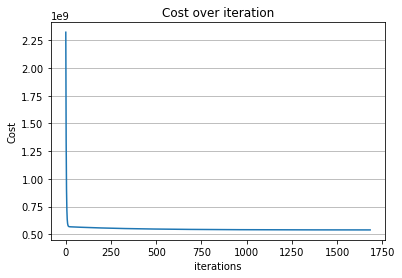

In [68]:
plt.plot(range(len(LR.cost)), LR.cost)  
plt.title("Cost over iteration")
plt.grid(axis="y")
plt.xlabel('iterations')
plt.ylabel('Cost')
plt.show()  

The linear regression model is trained, now use the model to predict the Loan Amount

In [69]:
y_pred_LR = LR.predict(test_df)
y_pred_LR

array([[ 37731.93884044],
       [109562.43743632],
       [ 91476.8988952 ],
       ...,
       [ 73604.4917154 ],
       [118475.58617777],
       [ 35294.54477904]])

# Regularized Linear Regression
To prevent the overfitting of the Linear Regression model, we can use a Regularized Linear Regression model.

It's a Linear Regression model with a extra Regularization Regression penalized term.

The Regularized Gradient Descent Algorithm are represented as follow:
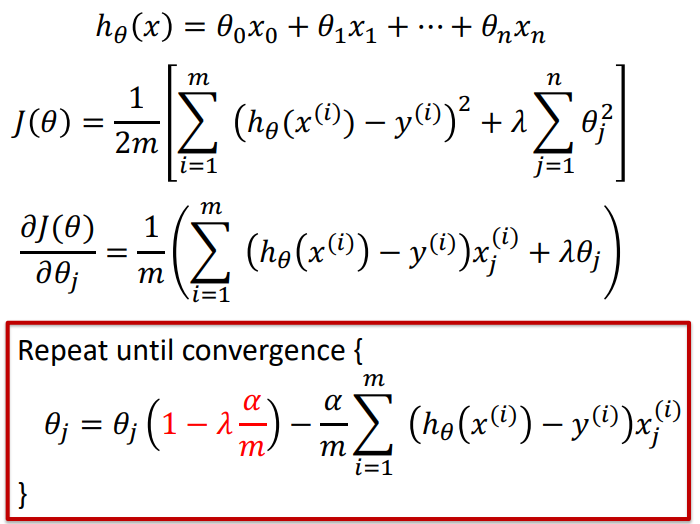



**Hypothesis Model:**
$$h_\theta(x)=\theta_0+\theta_1x_1+\theta_2x_2+...$$

**Cost function:**
$$J(\theta_0,\theta_1,...)=\frac{1}{2m}\sum_{i=1}^{m}(h_\theta (x^{(i)})-y^{(i)})^2$$

**Gradient Descent Algorithm:**
$$n=0, \theta[n]=0, x_0=0$$
Repeat until convergence {
  $$\theta[n+1] = \theta[n]-\frac{\alpha}{m}\sum_{i=1}^{m}(h_\theta (x^{(i)})-y^{(i)})x^{(i)}$$
}

In [70]:
class RegularizedLinearRegression:
    """
    Parameters
    ----------
    eta : float
        Learning rate
    eps : float
        Convergence criteria
    ld  : float
        lambda (control the tradeoff)
    n_iterations : int
        No of passes over the training set
   
    Attributes
    ----------
    theta : theta/ after fitting the model
    bias : bias / after fitting the model
    cost : total error of the model after each iteration
    """

    def __init__(self, eta, eps, ld,  n_iterations):
        self.eta = eta
        self.eps = eps
        self.ld = ld
        self.n_iterations = n_iterations

    def fit(self, x, y):
        """Fit the training data

        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Training samples
        y : array-like, shape = [n_samples, n_target_values]
            Target values

        Returns
        -------
        self : object
        """
          
        self.theta = np.zeros((x.shape[1], 1))
        self.bias = 0
        m = x.shape[0]
        self.cost = []
        self.cost.append(self.costfuntion(x,y))
        print('initial cost: ',self.cost)
    
        for i in range(self.n_iterations):
            y_pred = np.dot(x, self.theta)+self.bias
            residuals = y_pred - y
            gradient_vector = np.dot(x.T, residuals)
            self.bias = self.bias * (1 - self.ld * self.eta / m) - (self.eta / m) * np.sum(residuals)
            self.theta = self.theta * (1 - self.ld * self.eta / m) - (self.eta / m) * gradient_vector
            new_cost = self.costfuntion(x,y)
            cost_diff = self.cost[-1]-new_cost
            self.cost.append(new_cost)
            if (i%100 == 0):
              print('itr:',i)
              print('cost:', new_cost)
              print('cost_diff',cost_diff)
            if (cost_diff < self.eps):
              print('itr:',i)
              print('cost:', new_cost)
              print('cost_diff',cost_diff)
              break
        return self

    def costfuntion(self, x, y):
      m = x.shape[0]
      y_pred = np.dot(x, self.theta)+self.bias
      residuals = y_pred - y
      cost = (np.sum((residuals ** 2)) + self.ld * np.sum((self.theta ** 2)) )/ (2 * m)
      return cost


    def predict(self, x):
        """ Predicts the value after the model has been trained.
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Test samples
        Returns
        -------
        Predicted value
        """
        return np.dot(x, self.theta)+self.bias

Train the model with learning rate 0.000000000005, Convergence criteria 1000, lambda 1 and number of iterations 3000



In [71]:
RLR = RegularizedLinearRegression(0.000000000005, 1000, 1, 3000)
RLR.fit(x, y)

initial cost:  [2322818366.303193]
itr: 0
cost: 1730875618.7026997
cost_diff 591942747.6004934
itr: 100
cost: 562718274.2777468
cost_diff 61750.265167713165
itr: 200
cost: 557305718.6319348
cost_diff 47288.985241651535
itr: 300
cost: 553160423.5102179
cost_diff 36220.160187006
itr: 400
cost: 549985105.4680945
cost_diff 27747.925159573555
itr: 500
cost: 547552223.3031346
cost_diff 21263.124205112457
itr: 600
cost: 545687616.6128564
cost_diff 16299.508588433266
itr: 700
cost: 544257982.726417
cost_diff 12500.210938453674
itr: 800
cost: 543161291.5324318
cost_diff 9592.08451807499
itr: 900
cost: 542319448.9761752
cost_diff 7366.062466979027
itr: 1000
cost: 541672681.6911366
cost_diff 5662.124744653702
itr: 1100
cost: 541175238.988978
cost_diff 4357.791806459427
itr: 1200
cost: 540792103.1572559
cost_diff 3359.3176513910294
itr: 1300
cost: 540496471.5171741
cost_diff 2594.948967576027
itr: 1400
cost: 540267829.1874274
cost_diff 2009.7656767368317
itr: 1500
cost: 540090473.9752327
cost_diff

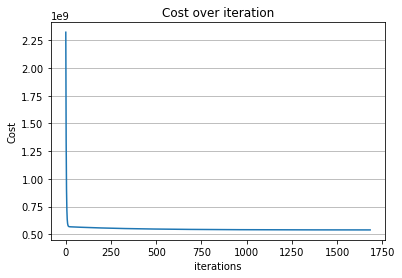

In [72]:
plt.plot(range(len(RLR.cost)), RLR.cost)  
plt.title("Cost over iteration")
plt.grid(axis="y")
plt.xlabel('iterations')
plt.ylabel('Cost')
plt.show()  

The Regularized Linear Regression model is trained, now use the model to predict the Loan Amount

In [73]:
y_pred_RLR = RLR.predict(test_df)
y_pred_RLR

array([[ 37731.93884044],
       [109562.43743632],
       [ 91476.8988952 ],
       ...,
       [ 73604.4917154 ],
       [118475.58617777],
       [ 35294.54477904]])

#Deep Neural Network


import the required package first

In [74]:
from pandas.core.common import standardize_mapping
from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout

Building DNN using keras

The DNN model has two hidden layer

Both hidden layer has 64 Neurons, activation function is 'relu'

The configuretion of model:


*   optimizer: adam
*   loss function: mean square error (mse)


Show the Mean Absolute Error and Mean Absolute Percentage Error of each epoch



In [75]:
def create_DNN():
  DNN = Sequential()
  DNN.add(Dense(64, input_dim=x.shape[1], activation='relu'))
  DNN.add(Dense(64, activation='relu'))
  DNN.add(Dense(1)) 
  DNN.compile(loss='mse', 
                optimizer='adam',
                metrics=['mae','mape'])
  return DNN

In [76]:
DNN = create_DNN()

DNN.fit(x, y,epochs=40,batch_size=40)

Epoch 1/40
659/659 [==============================] - 2s 2ms/step - loss: 1106115584.0000 - mae: 23180.2949 - mape: 12153682657280.0000
Epoch 2/40
659/659 [==============================] - 1s 2ms/step - loss: 1092712192.0000 - mae: 23179.7344 - mape: 12080264511488.0000
Epoch 3/40
659/659 [==============================] - 1s 2ms/step - loss: 1081692800.0000 - mae: 23163.4668 - mape: 12030363828224.0000
Epoch 4/40
659/659 [==============================] - 1s 2ms/step - loss: 1080781312.0000 - mae: 23246.2051 - mape: 12009770844160.0000
Epoch 5/40
659/659 [==============================] - 1s 2ms/step - loss: 1085605120.0000 - mae: 23188.2363 - mape: 12024797986816.0000
Epoch 6/40
659/659 [==============================] - 1s 2ms/step - loss: 1084889728.0000 - mae: 23232.1855 - mape: 12022163963904.0000
Epoch 7/40
659/659 [==============================] - 1s 2ms/step - loss: 1083102464.0000 - mae: 23290.6074 - mape: 11965453828096.0000
Epoch 8/40
659/659 [============================

Predict with the trained DNN model

In [77]:
y_pred_DNN = DNN.predict(test_df)
y_pred_DNN

array([[ 41272.73 ],
       [102123.76 ],
       [ 87198.58 ],
       ...,
       [ 72852.05 ],
       [121445.445],
       [ 37437.477]], dtype=float32)

##DNN2
I make another approach of training the model.


As the traning data set can split into two set, one is accepted loan (loan amount > 0), one is unaccepted loan (loan anount = 0), so we create an array "loan_accepted" to indicate that.

In [78]:
loan_acceptance = y.copy()
loan_acceptance[loan_acceptance > 0] = 1

We first build the model of predict loan accepted


Standardize the dataset:

In [79]:
df = pd.concat([x, test_df], ignore_index=True)
min_max_scaler = preprocessing.MinMaxScaler()
df_st = min_max_scaler.fit_transform(df)
x_std = df_st[:df_st.shape[0]-3000]
test_std = df_st[df_st.shape[0]-3000:]

Building DNN_acceptance using keras

The model has two hidden layer

Both hidden layer has 64 Neurons, activation function is 'relu'

The output layer's activation function is 'sigmoid'

The configuretion of model:


*   optimizer: adam
*   loss function: binary crossentropy


Show the accuracy of each epoch

In [80]:
DNN_acceptance = Sequential()
DNN_acceptance.add(Dense(64, input_dim=x_std.shape[1], activation='relu'))
DNN_acceptance.add(Dense(64, activation='relu'))
DNN_acceptance.add(Dense(1, activation='sigmoid'))
DNN_acceptance.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

DNN_acceptance.fit(x_std, loan_acceptance,epochs=40,batch_size=40)

Epoch 1/40
659/659 [==============================] - 2s 2ms/step - loss: 0.4214 - accuracy: 0.8316
Epoch 2/40
659/659 [==============================] - 1s 2ms/step - loss: 0.3555 - accuracy: 0.8825
Epoch 3/40
659/659 [==============================] - 1s 2ms/step - loss: 0.3402 - accuracy: 0.8890
Epoch 4/40
659/659 [==============================] - 1s 2ms/step - loss: 0.3309 - accuracy: 0.8930
Epoch 5/40
659/659 [==============================] - 1s 2ms/step - loss: 0.3232 - accuracy: 0.8959
Epoch 6/40
659/659 [==============================] - 1s 2ms/step - loss: 0.3148 - accuracy: 0.8984
Epoch 7/40
659/659 [==============================] - 1s 2ms/step - loss: 0.3075 - accuracy: 0.9009
Epoch 8/40
659/659 [==============================] - 1s 2ms/step - loss: 0.3026 - accuracy: 0.9017
Epoch 9/40
659/659 [==============================] - 1s 2ms/step - loss: 0.2987 - accuracy: 0.9026
Epoch 10/40
659/659 [==============================] - 1s 2ms/step - loss: 0.2955 - accuracy: 0.9029

Predict the loan acceptance of the testing dataset

In [81]:
y_pred_acceptance = np.round_(DNN_acceptance.predict(test_std))
unique, counts = np.unique(y_pred_acceptance, return_counts=True)
dict(zip(unique, counts))

{0.0: 579, 1.0: 2421}

Build the DNN model (DNN2) of accepted loan customer's loan amount, the setting is same as the first DNN model.

In [82]:
DNN2 = create_DNN()

Get the accepted customer data from the traing dataset

In [83]:
x_accepted = train_df[train_df["Loan Amount"] > 0]
y_accepted = x_accepted.pop("Loan Amount")
y_accepted = y_accepted.values.reshape(len(y_accepted),1)

Train the DNN2 model

In [84]:
DNN2.fit(x_accepted, y_accepted, epochs=40,batch_size=40)

Epoch 1/40
482/482 [==============================] - 1s 2ms/step - loss: 191496608.0000 - mae: 6460.9194 - mape: 9.9444
Epoch 2/40
482/482 [==============================] - 1s 2ms/step - loss: 39581020.0000 - mae: 4259.4219 - mape: 6.4315
Epoch 3/40
482/482 [==============================] - 1s 2ms/step - loss: 40453548.0000 - mae: 4280.9473 - mape: 6.4485
Epoch 4/40
482/482 [==============================] - 1s 2ms/step - loss: 40178668.0000 - mae: 4284.0625 - mape: 6.4567
Epoch 5/40
482/482 [==============================] - 1s 2ms/step - loss: 39432888.0000 - mae: 4257.6860 - mape: 6.4348
Epoch 6/40
482/482 [==============================] - 1s 2ms/step - loss: 39323624.0000 - mae: 4238.0005 - mape: 6.3691
Epoch 7/40
482/482 [==============================] - 1s 2ms/step - loss: 40354720.0000 - mae: 4283.1035 - mape: 6.4584
Epoch 8/40
482/482 [==============================] - 1s 2ms/step - loss: 39436452.0000 - mae: 4257.4780 - mape: 6.4045
Epoch 9/40
482/482 [===================

In [85]:
y_pred_DNN2 = DNN2.predict(test_df) * y_pred_acceptance
y_pred_DNN2

array([[ 48193.777],
       [139812.69 ],
       [117358.44 ],
       ...,
       [ 94814.92 ],
       [     0.   ],
       [     0.   ]], dtype=float32)

#Performance evaluation and discussions 


First compare the Linear Regression (LR) and Regularized Linear Regression (RLR) model. The cost of this two model after traning are 539861934 and 539861934, it's very close. As RLR model cost function include an extra regularized cost, it can prevent overfitting of the model, so RLR is more prefer than LR. 


Then compare the two Deep Neural Network model - DNN, and the combination of DNN_acceptance and DNN2. DNN and DNN2 use the same model but different training data, as DNN use the all customers data and DNN2 only use the accepted customers data. We can see that all the mean square error (MSE), mean absolute error (MAE) and  mean absolute percentage error (MAPE) of DNN2 is much lower than DNN.

| Model | MSE | MAE | MAPE         
| ----- | ------: | ------: | -----:
| DNN | 1072337856 | 23102.255 | 11997613654016.0000
| DNN2 | 38637864  | 4224.297  | 6.3832

Especially the MAPE, the diffence is 1879560981015 times. We can clearly see that use the only use the accepted customers data to predict the loan amount is much more acurrate. I think the reason is because the unaccepted customers account for arround a quarter of all, it quite a large amonnt, as their loan ammount are all 0, it makes DNN bias to them when training and the error become large. DNN2 only consider the accepted customers, the model will not bias the unaccepted customers. DNN2 require an acceptance prediction, so we hane DNN_acceptance, and the acurracy is 0.9129 which means the model is nice. As a result DNN2 is much better than DNN.


Last we compare RLR and DNN2. As RLR's traing is not quite linear and have many outlier as it contain many unaccepted customers, the model will not acurrate. So I think that the predicted result of DNN2 (y_pred_DNN2) is the most acurrate.


Output the LR model presiction result to 20037676D_LR.csv

In [86]:
result_LR = pd.DataFrame( np.concatenate((test_ID.values.reshape(len(test_ID), 1) ,y_pred_LR),axis=1), columns = [ 'Customer_ID', 'Loan Amount' ])
result_LR

,Customer_ID,Loan Amount
0,C-6692,37731.93884
1,C-25987,109562.437436
2,C-5051,91476.898895
3,C-12745,66413.294401
4,C-8292,14139.847145
...,...,...
2995,C-11467,14565.559299
2996,C-35487,88901.495783
2997,C-23221,73604.491715
2998,C-25999,118475.586178


In [87]:
result_LR.to_csv('20037676D_LR.csv', index = False)

Output the RLR model presiction result to 20037676D_RLR.csv

In [88]:
result_RLR = pd.DataFrame( np.concatenate((test_ID.values.reshape(len(test_ID), 1) ,y_pred_RLR),axis=1), columns = [ 'Customer_ID', 'Loan Amount' ])
result_RLR

,Customer_ID,Loan Amount
0,C-6692,37731.93884
1,C-25987,109562.437436
2,C-5051,91476.898895
3,C-12745,66413.294401
4,C-8292,14139.847145
...,...,...
2995,C-11467,14565.559299
2996,C-35487,88901.495783
2997,C-23221,73604.491715
2998,C-25999,118475.586178


In [89]:
result_RLR.to_csv('20037676D_RLR.csv', index = False)

Output the DNN model presiction result to 20037676D_DNN.csv

In [90]:
result_DNN = pd.DataFrame( np.concatenate((test_ID.values.reshape(len(test_ID), 1) ,y_pred_DNN),axis=1), columns = [ 'Customer_ID', 'Loan Amount' ])
result_DNN

,Customer_ID,Loan Amount
0,C-6692,41272.730469
1,C-25987,102123.757812
2,C-5051,87198.578125
3,C-12745,67945.992188
4,C-8292,14385.511719
...,...,...
2995,C-11467,14243.973633
2996,C-35487,84990.265625
2997,C-23221,72852.046875
2998,C-25999,121445.445312


In [91]:
result_DNN.to_csv('20037676D_DNN.csv', index = False)

Output the DNN2 model presiction result to 20037676D_DNN2.csv

In [92]:
result_DNN2 = pd.DataFrame( np.concatenate((test_ID.values.reshape(len(test_ID), 1) ,y_pred_DNN2),axis=1), columns = [ 'Customer_ID', 'Loan Amount' ])
result_DNN2

,Customer_ID,Loan Amount
0,C-6692,48193.777344
1,C-25987,139812.6875
2,C-5051,117358.4375
3,C-12745,84812.882812
4,C-8292,17965.021484
...,...,...
2995,C-11467,18655.712891
2996,C-35487,113613.335938
2997,C-23221,94814.921875
2998,C-25999,0.0


In [93]:
result_DNN2.to_csv('20037676D_DNN2.csv', index = False)

#Summary

We have built 4 model - Linear Regression, Regularized Linear Regression, Deep Neural Network and a special DNN model which separate as two parts. And we found that the last model has the least error and is most accurate.

# Future work 
The idea of DNN2 can be also implement by regression model. The acceptance prediction can implemented by Logistic Regression and the accepted customers' loan amount prediction just use Linear Regression. This model can be include in the furtue work.

#Reference


*   API reference — pandas 1.4.2 documentation https://pandas.pydata.org/docs/reference/index.html
*   NumPy Reference — NumPy v1.22 Manual https://numpy.org/doc/stable/reference/index.html
*   Keras API reference https://keras.io/api/

